# Import libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


from collections import defaultdict
from time import time

# Load Data

In [2]:
# Load 3 categories: "sci.space", "soc.religion.christian", "talk.politics.guns"
categories = [
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

# Get the labels of each sample
labels = dataset.target

# Count the number of samples in each category and the number of categories
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

# Print the number of documents and the number of categories
print(f"{len(dataset.data)} documents - {true_k} categories")

2894 documents - 3 categories


# Fit and Evaluate the K-means Model


In [3]:
# Initialize lists to store evaluation results
evaluations = []
evaluations_std = []

# Function to train and evaluate the K-means model
def fit_and_evaluate(km, X, name=None, n_runs=5):
    
    # Get the name of the model if not specified
    name = km.__class__.__name__ if name is None else name

    # List to store training times
    train_times = []
    
    # Compute evaluation scores
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()  # Start measuring time
        km.fit(X)
        train_times.append(time() - t0)
        
        # Evaluate the model
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    # Print the average training time and standard deviation
    print(f"Clustering executed in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    
    # Print evaluation scores and store them
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
        
    # Add evaluation results to the lists
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## TfidfVectorizer

###  Feature Extraction with TfidfVectorizer

In [4]:
# Feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"Vectorization executed in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

Vectorization executed in 0.285 s
n_samples: 2894, n_features: 7429


In [5]:
vectorizer.get_feature_names_out()

array(['00', '000', '00000', ..., 'zero', 'zip', 'zone'], dtype=object)

In [6]:
print(f"Sparsity of the TF-IDF matrix: {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

Sparsity of the TF-IDF matrix: 0.008


In [7]:
print(X_tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Cluster Sparse Data using K-means

In [8]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

Clustering executed in 0.07 ± 0.02 s 
Homogeneity: 0.389 ± 0.033
Completeness: 0.461 ± 0.025
V-measure: 0.422 ± 0.030
Adjusted Rand-Index: 0.286 ± 0.052
Silhouette Coefficient: 0.009 ± 0.000


### Dimensionality Reduction using LSA

In [9]:
# Perform dimensionality reduction using LSA
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA executed in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA executed in 0.694 s
Explained variance of the SVD step: 18.6%


In [10]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

Clustering executed in 0.05 ± 0.00 s 
Homogeneity: 0.439 ± 0.079
Completeness: 0.524 ± 0.034
V-measure: 0.476 ± 0.061
Adjusted Rand-Index: 0.362 ± 0.088
Silhouette Coefficient: 0.031 ± 0.001


### Top Terms in Each Cluster

In [11]:
# Top terms in each cluster
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: space orbit nasa launch shuttle moon earth mission like satellite 
Cluster 1: gun people don like just know think fbi right guns 
Cluster 2: god jesus church christian christ christians people bible believe faith 


## HashingVectorizer

In [12]:
# HashingVectorizer
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"Vectorization executed in {time() - t0:.3f} s")

Vectorization executed in 2.281 s


In [13]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

Clustering executed in 0.02 ± 0.01 s 
Homogeneity: 0.487 ± 0.112
Completeness: 0.550 ± 0.054
V-measure: 0.514 ± 0.089
Adjusted Rand-Index: 0.465 ± 0.160
Silhouette Coefficient: 0.032 ± 0.002


# Evaluate Clustering

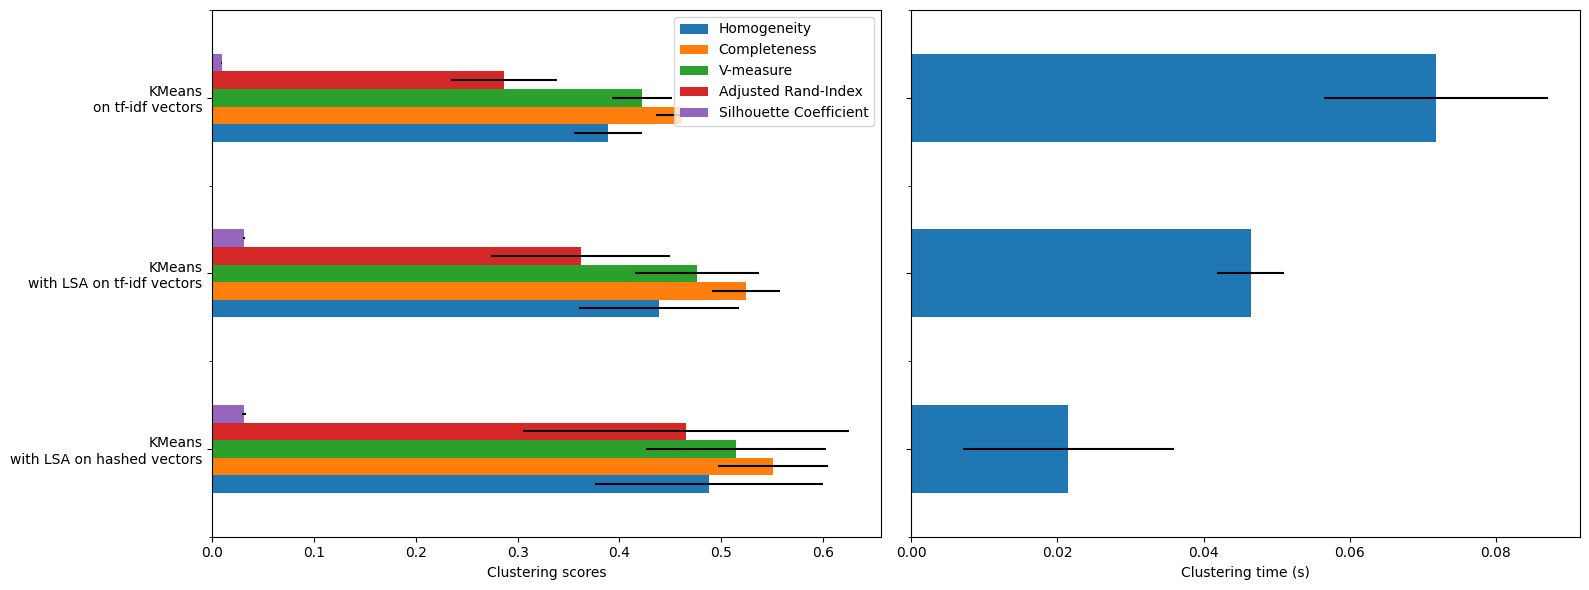

In [14]:
# Evaluate clustering
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()
